# Time Series Anomaly Detection by Image Classification

One of my day jobs is to help people with early detection of unusual behavior in system or business metrics.  These can be cloud service performance or reliability metrics, application reliability on PCs, online product purchases, and many other metrics. An example is this time series pictured here.  

We have a dataset of time series that we worked with experts to label with time periods that they want to be detected.  Because we want early detection, we want to classify a time series as anomalous as soon as an anomaly appears, which is to say, at the right edge of an image like this one.  The normal approach to this problem is to use various moving average, exponential smoothing, or regression algorithms, or neural networks such as LSTM directly on the time series sequence data.  

I am taking the `fast.ai` deep learning course.  For fun, I decided to see what would happen if instead, I used a convolutional neural network on an IMAGE of the time series chart instead of the sequence data. 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

## Time Series Dataset

The time series dataset is a Microsoft dataset that we plan to publish in the future.  The dataset includes a variety of distinct problem domains such as cloud service request rates, product purchase counts, application crash rates, and API latencies.  The dataset is annotated with anomalies - that is, time slices where experts have indicated that they want to be notified to investigate for possible issues.  

The dataset contains over 100 distinct anomalies.  I generated bitmaps of the time series charts with the anomaly time slices at the right edge of the chart.  Then I took a random sample of around 400 time windows of non-anomalous time series and generated bitmaps of those as well.

I initially had issues reading in these images in the way I want with the `fast.ai` library.  The default behavior of `fast.ai` is to crop images, which doesn't work well for this application because it is critical that the anomaly time points are kept at the right position of the image.  For similar reasons, I did not want any rotation or image flipping.  After some experimentation, I settled on manually resizing and zero padding all images to 224x224 for consistentcy.

These are placed in the `bitmaps` directory of this repository.

In [3]:
# Initialize a consistent random seed
np.random.seed(2)
# Set batch size
bs = 64

### Load dataset from folder

In [4]:
data = ImageDataBunch.from_folder('bitmaps', df_tfms=get_transforms(do_flip=False, max_zoom=1), size=224, bs=bs, valid_pct=0.2)

In [5]:
data.normalize(imagenet_stats)

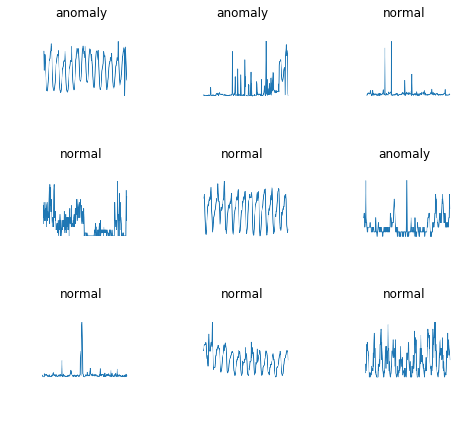

In [6]:
data.show_batch(rows=3, figsize=(7,6))

In [7]:
print(data.classes)
len(data.classes),data.c

['anomaly', 'normal']


(2, 2)

## Training: resnet34

We follow the approach of `fast.ai` lesson 1 and start with resnet34 architecture for our model.

We will train for 10 epochs.

In [8]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [9]:
learn.fit_one_cycle(10)

Total time: 00:18
epoch  train_loss  valid_loss  error_rate
1      0.881580    0.781101    0.536585    (00:02)
2      0.695174    0.578621    0.349594    (00:01)
3      0.542768    0.367953    0.162602    (00:01)
4      0.414112    0.505873    0.235772    (00:01)
5      0.321434    0.242793    0.097561    (00:01)
6      0.252862    0.145653    0.032520    (00:01)
7      0.202013    0.138588    0.024390    (00:01)
8      0.165065    0.130093    0.024390    (00:01)
9      0.138060    0.128331    0.024390    (00:01)
10     0.116388    0.128089    0.024390    (00:01)



Amazingly, we get error rate of 3.25%!  This is somewhat surprising because we mixed up different metric domains.  We generally find with other algorithms that each time series behaves differently.

In [10]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [37]:
interp = ClassificationInterpretation.from_learner(learn)

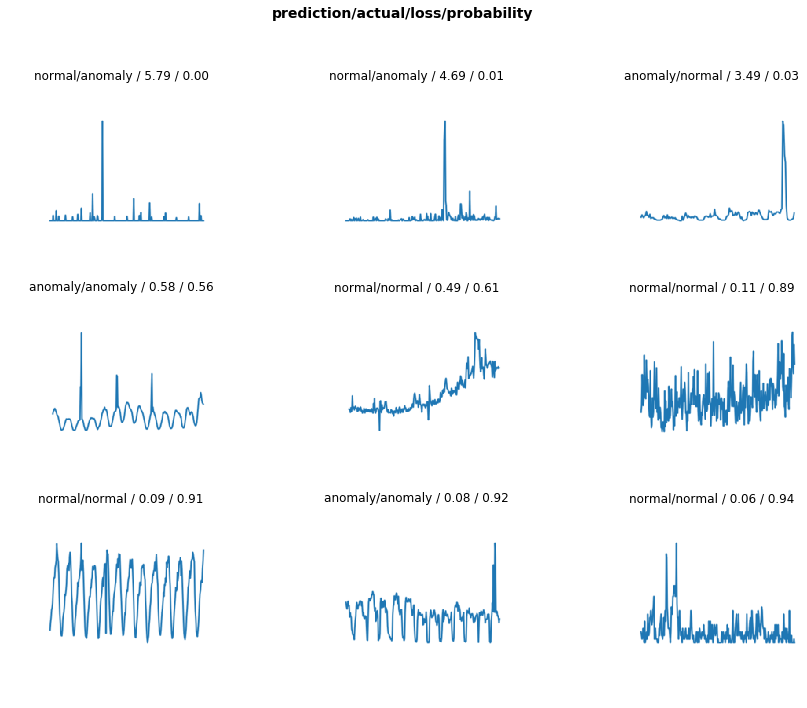

In [38]:
interp.plot_top_losses(9, figsize=(15,11))

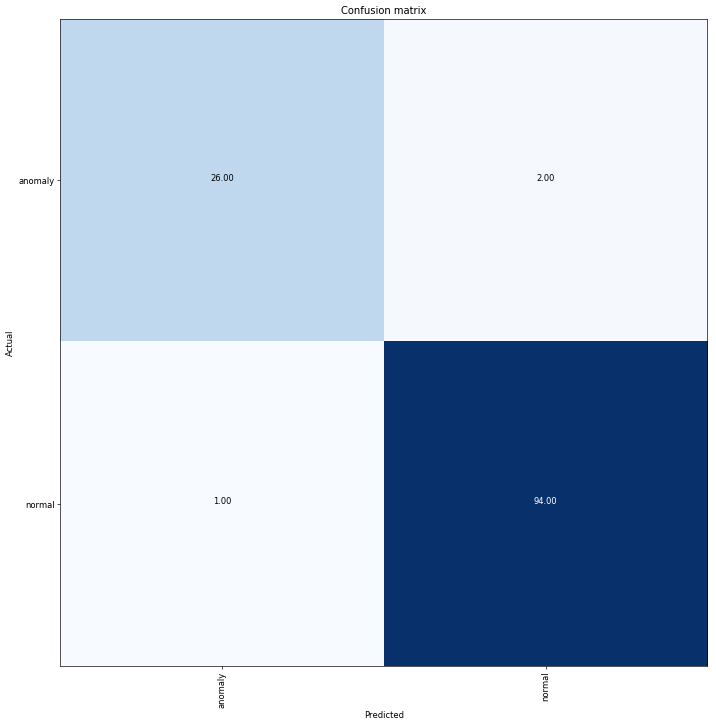

In [39]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [40]:
interp.most_confused(min_val=2)

[]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [15]:
learn.unfreeze()

In [16]:
learn.fit_one_cycle(1)

Total time: 00:02
epoch  train_loss  valid_loss  error_rate
1      0.624110    32.504482   0.772358    (00:02)



In [35]:
learn.load('stage-1')

In [23]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


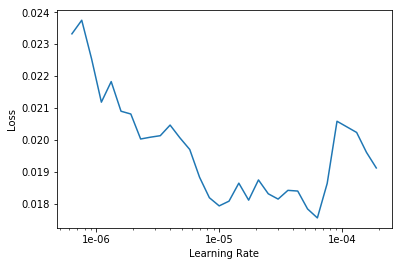

In [24]:
learn.recorder.plot()

In [36]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-6,5e-5))

Total time: 00:21
epoch  train_loss  valid_loss  error_rate
1      0.015585    0.125522    0.024390    (00:02)
2      0.014140    0.124565    0.024390    (00:02)
3      0.015276    0.145958    0.024390    (00:02)
4      0.013339    0.150840    0.040650    (00:02)
5      0.013032    0.142768    0.040650    (00:02)
6      0.012381    0.135628    0.032520    (00:02)
7      0.010649    0.132180    0.024390    (00:02)
8      0.009463    0.131450    0.024390    (00:02)
9      0.008897    0.129096    0.024390    (00:02)
10     0.008093    0.129631    0.024390    (00:02)



## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [26]:
data2 = ImageDataBunch.from_folder('bitmaps', df_tfms=get_transforms(do_flip=False, max_zoom=1), size=224, bs=bs//2, valid_pct=0.2)


In [27]:
data2.normalize(imagenet_stats)

In [28]:
learn2 = create_cnn(data2, models.resnet50, metrics=error_rate)

In [29]:
learn2.fit_one_cycle(10)

Total time: 00:29
epoch  train_loss  valid_loss  error_rate
1      0.714029    0.721486    0.451852    (00:05)
2      0.470686    0.498920    0.192593    (00:02)
3      0.337360    0.209552    0.088889    (00:02)
4      0.249762    0.199853    0.074074    (00:02)
5      0.184177    0.179076    0.059259    (00:02)
6      0.134200    0.128874    0.037037    (00:02)
7      0.102580    0.134938    0.044444    (00:02)
8      0.075759    0.162498    0.029630    (00:02)
9      0.058497    0.165538    0.037037    (00:02)
10     0.044666    0.165741    0.044444    (00:02)



In [30]:
learn2.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [31]:
learn2.unfreeze()
learn2.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

Total time: 00:11
epoch  train_loss  valid_loss  error_rate
1      0.012719    0.145306    0.029630    (00:04)
2      0.009341    0.137647    0.037037    (00:03)
3      0.010234    0.136459    0.029630    (00:03)



If it doesn't, you can always go back to your previous model.

In [32]:
learn2.load('stage-1-50')

In [33]:
interp = ClassificationInterpretation.from_learner(learn2)

In [34]:
interp.most_confused(min_val=2)

[('anomaly', 'normal', 5)]